<a href="https://colab.research.google.com/github/tonyscan6003/IntroToVision/blob/main/Example_2_3_Eigenfaces%26FisherFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Facial Recognition with Eigenfaces & Fisherfaces

![Eigenfaces](https://github.com/tonyscan6003/CE6003/blob/master/images/eigenfaces.jpg?raw=true)

In this example we will obtain eigenfaces from a small dataset of faces.
We will demonstrate reconstraction of faces with the eigenfaces.
We will train a Classifier and demonstrate facial recognition.  We will use the ["Yale Faces"]http://vision.ucsd.edu/content/yale-face-database dataset that contains 15 people with 10 examples for each face. This dataset is reasonbly challenging as it includes images of each person with different illuminations and poses. We need to use a sufficiently complex dataset so the improvement of the LDA (Fisherface) approach can be seen over the PCA (Eigenface approach)

This example is based on the [scikit Learn tutorial](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html) 

#HouseKeeping:
Import Packages, import dataset, divide data in train and validation splits for k fold cross validation.

In [ ]:
from sklearn import datasets
from skimage import feature
from skimage import exposure
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import decomposition
import numpy as np
import urllib
import cv2
import matplotlib.pyplot as plt

Load & display the Yale Faces [1] - This consists of 165 grayscale images in GIF format of 15 individuals. There are 11 images per subject in various poses and illuminations. This dataset is more challenging than the basic olivetti dataset. We will download a [modified version](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/) of the dataset with faces already centered.

[1] Belhumeur, P.N., Hespanha, J.P. and Kriegman, D.J., 1997. Eigenfaces vs. fisherfaces: Recognition using class specific linear projection. IEEE Transactions on pattern analysis and machine intelligence, 19(7), pp.711-720.

In [ ]:
#!wget "http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip"  
!wget "https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz"

--2021-04-22 08:05:58--  https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/YALE.tar.gz
Resolving vismod.media.mit.edu (vismod.media.mit.edu)... 18.27.72.36
Connecting to vismod.media.mit.edu (vismod.media.mit.edu)|18.27.72.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30032961 (29M) [application/x-gzip]
Saving to: ‘YALE.tar.gz’

YALE.tar.gz         100%[===================>]  28.64M  80.9MB/s    in 0.4s    

2021-04-22 08:05:59 (80.9 MB/s) - ‘YALE.tar.gz’ saved [30032961/30032961]



In [ ]:

!tar -xzf YALE.tar.gz
#!ls YALE/centered

In [ ]:
# Read file list: 
import glob
img_list = glob.glob('YALE/centered/subject*')

In [ ]:

w = 195        # Original image height and width
h =231

# Code to read files into dataset with labels.
def read_images(img_list):
   train_pos = np.empty([1,h*w])
   labels = np.empty([])
   # Function to read images from file list 
   for i in range(len(img_list)): 
      img_path = img_list[i]
      curr_label = img_path.split('.')[0]
      curr_label = curr_label.split('/')[2]
      curr_label = curr_label.split('t')[1]
      img=cv2.imread(img_path,-1)
      #  store image as row in array
      train_pos = np.concatenate((train_pos,np.reshape(img, (1, w*h)))) if i>0 else np.reshape(img, (1, w*h))
      labels = np.append(labels,curr_label) if i>0 else curr_label
   return train_pos,labels 

all_img,all_labels = read_images(img_list)


In [ ]:
print(np.shape(all_img))

(165, 45045)


In [ ]:
# Convert the text labels to numbers to allow the dataset be compatible with Sklearn classifiers.
le = preprocessing.LabelEncoder()
le.fit(all_labels)
all_labels_tx = le.transform(all_labels)

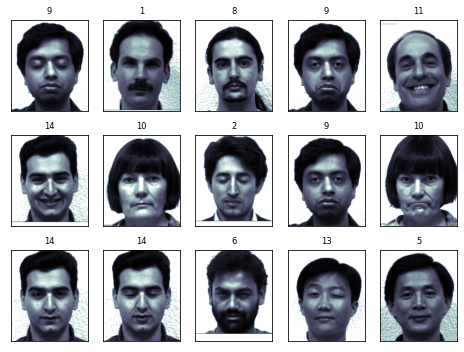

In [ ]:
# Create Plot
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(all_img[i].reshape(h,w), cmap=plt.cm.bone)
    ax.set_title(all_labels_tx[i],
                 fontsize='small')

Using the [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) to generate idices for test and training sets with same % distributions. By setting the test_size varible to 15 which is the number of different people in the training set, we get one example per person in the validation set. This is the same approach as the original paper. We can generate K splits allowing us to use cross validation to check our results.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=15, random_state=1)
sss.get_n_splits(all_img, all_labels_tx)
for train_data,test_data in sss.split(all_img, all_labels_tx):
    print(all_labels_tx[test_data]) 

[ 0  1 14  2  4  3  5 11  9  7 10  8 13 12  6]
[13 12 11  4  5  9 14  1  0  8  2  7  6 10  3]
[ 4 12  8 11  1  6  2  9  5  3  7 10 14  0 13]
[12 13 14  2  0  1  6  5  4  7 10  8  3 11  9]
[ 1  2 12 13 11  7  6  8 14 10  4  3  5  9  0]


## Creating the Eigenfaces
As we saw in the Video lesson on Eigenfaces we use Principle Component Analysis to obtain eigenvectors. The sklearn python package has a built in PCA function to enable us to quickly determine the eigenfaces from the databased of faces. We can set the parameter `n_eigenfaces` which sets the number of pca components to use as Eigenfaces, using fewer eigenfaces will give a more compact representation of the faces. However as we will see in the next section this representation is lossy and faces cannot be completely reconstructed.

In [ ]:
n_eigenfaces = 10  # Number of eigenfaces to return (max 165)

In [ ]:

pca = decomposition.PCA(n_components=n_eigenfaces, whiten=True)
pca.fit(all_img)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

We wil display the 1st 30 eigenfaces obtained from the PCA. The ith eigenvector is accessed by pca.components_[i] 

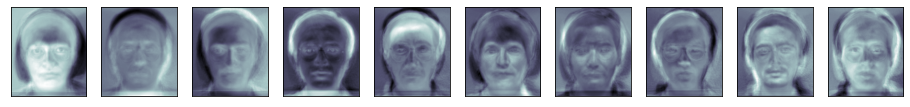

In [ ]:
fig = plt.figure(figsize=(16, 6))
for i in range(min(30,n_eigenfaces)):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((h,w)),
              cmap=plt.cm.bone)

## Transforming the Database & Reconstructing faces
In this step we will transform the database of faces into it's eigenface representation. This will give use a vector for each face equal to the number of eigenfaces we choose to retain (max number of Eigenfaces = Number of faces in database -1)

 In the previous step we could set the parameter n_eigenfaces which controls how many eigenfaces to retain. We will investigate the quality of the face reconstruction by varying this number from a low value 5 to the max value 299, trying some values inbetween.

In [ ]:
# Apply the transformation to the entire dataset
all_img_pca = pca.transform(all_img)

We then will apply the inverse PCA transform. Which will give us back the reconstructed faces. (Take a look at the [stackoverflow post](https://stackoverflow.com/questions/55533116/pca-inverse-transform-in-sklearn)  which explains these 2 steps for 2D data.)

In [ ]:
# Apply the inverse transform to training set
all_img_recon = pca.inverse_transform(all_img_pca)

We will then plot some pairs of original faces from the dataset and the reconstructed faces from the representation in our database using Eigenfaces. Change the number of eigenfaces (n_eigenfaces) above and run all the code cells from Creating the Eigenfaces to the cell below to see the quality of the reconstructed faces.

Text(0.5, 0.98, 'Pairs of Original Database face & Reconstucted Faces from Databse with Eigenface representation = 10')

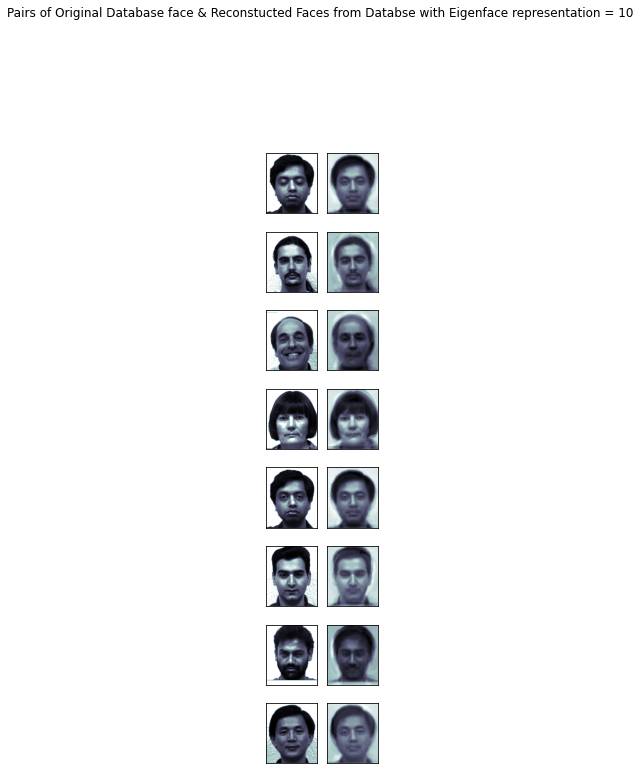

In [ ]:
fig = plt.figure(figsize=(2, 20))
# plot several images
for i in range(16):
    ax = fig.add_subplot(14, 2, i + 1, xticks=[], yticks=[])   
    if i % 2  ==0:
       # plot oringial face
       ax.imshow(all_img[i].reshape(h,w), cmap=plt.cm.bone)
    else:
       #plot reconstructed face 
       ax.imshow(all_img_recon[i-1].reshape(h,w), cmap=plt.cm.bone)
fig.suptitle('Pairs of Original Database face & Reconstucted Faces from Databse with Eigenface representation = '+str(n_eigenfaces)) 

## Recognition
In the code cell below we will train a nearest neighbour classifier to perform recognition. We can also try training a Support vector machine classifier and see if that improves the results (In a case where we just have one image per person we would be restricted to using k nearest neighbors). We can evaulate the performance of the classifier by using [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) with previously determined indices.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
#clf = svm.SVC(C=5., gamma=0.001)
clf.fit(all_img_pca, all_labels_tx)
scores = cross_val_score(clf, all_img_pca, all_labels_tx, cv=sss)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


0.83 accuracy with a standard deviation of 0.12


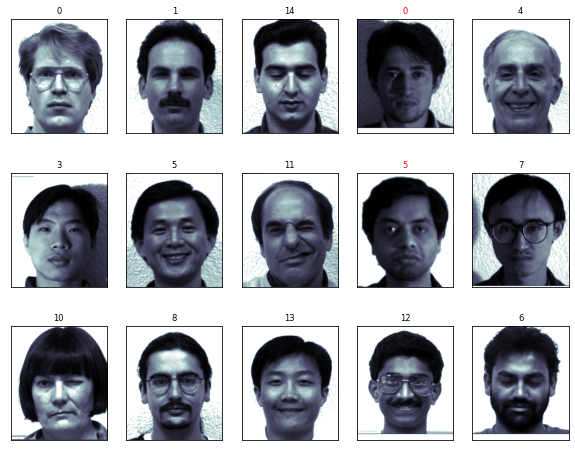

In [ ]:

train_data,test_data =next(sss.split(all_img, all_labels_tx))

fig = plt.figure(figsize=(10, 8))
cntr=1
for i in test_data:
    ax = fig.add_subplot(3, 5, cntr, xticks=[], yticks=[])
    ax.imshow((all_img[i,:].reshape(h,w)),cmap=plt.cm.bone)
    y_pred = clf.predict(all_img_pca[i, np.newaxis])[0]
    #y_pred = clf.predict(np.expand_dims(all_img_pca[i, :],0))[0]
    color = ('black' if y_pred == all_labels_tx[i] else 'red')
    ax.set_title(y_pred,
                 fontsize='small', color=color)
    cntr+=1

In [ ]:
print(np.shape(np.expand_dims(all_img[i, :],0)))

(1, 45045)


#Linear Discriminant Analysis
We can also try applying [LDA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py) to our data to see if that improves performance compared to the PCA approach. We again use Sklearn built in functions to quickly perform LDA. In the PCA approach we choose the number of eigenvectors to use in our appraoch. We observed that more eigenvectors improved the results of both reconstruction and classification. We should note that in the LDA approach the number of dimensions in the transformed data is at most always the number of classes -1. Thus LDA can greatly reduce the dimensionality of the data. It therefore will tend to work best when there are multiple classes such as in the face recognition example in this notebook. It may overly reduce the dimensionality for a binary classification problem.   

In [ ]:
n_classes=4
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=n_classes-1) # Set n_components to n classes-1
all_img_lda = lda.fit(all_img, all_labels_tx).transform(all_img)

In [ ]:
from sklearn.model_selection import cross_val_score
#clf = svm.SVC(C=5., gamma=0.001)
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(all_img_lda, all_labels_tx)
scores = cross_val_score(clf, all_img_lda, all_labels_tx, cv=sss)

In [ ]:
print(scores)

[1.         0.93333333 1.         0.93333333 0.8       ]


In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.93 accuracy with a standard deviation of 0.07


Plot some examples of the Test Set (Any errors in subject labelling will be highlighted in red font)

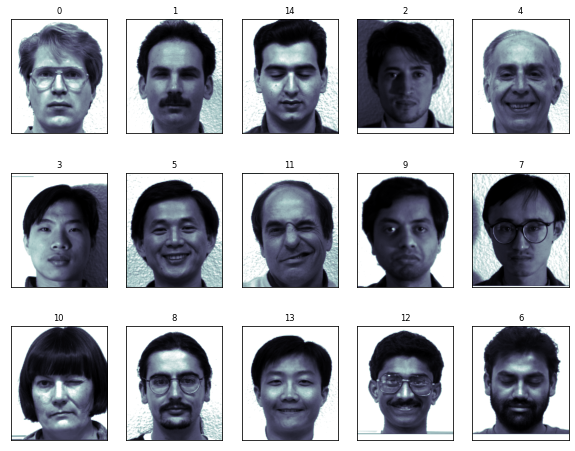

In [ ]:
train_data,test_data =next(sss.split(all_img, all_labels_tx))

fig = plt.figure(figsize=(10, 8))
cntr=1
for i in test_data:
    ax = fig.add_subplot(3, 5, cntr, xticks=[], yticks=[])
    ax.imshow((all_img[i,:].reshape(h,w)),cmap=plt.cm.bone)
    y_pred = clf.predict(all_img_lda[i, np.newaxis])[0]
    #y_pred = clf.predict(np.expand_dims(all_img_pca[i, :],0))[0]
    color = ('black' if y_pred == all_labels_tx[i] else 'red')
    ax.set_title(y_pred ,
                 fontsize='small', color=color)
    cntr+=1